## Importing the Necessary Libraries

In [25]:
# importing the standard libraries
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from types import SimpleNamespace
from sklearn.metrics import accuracy_score
from tqdm import tqdm

warnings.filterwarnings("ignore")

# importing pytorch libraries
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import transforms
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

## Step 1: Prepare and Explore Data

In [2]:
"""
First things first, to solve a multi-class problem (i.e. 1 output with multiple classes/unique values),
we want to make sure that for each plant folder in the 'plant_image_data folder', there is at least more than 1 image.
So to make sure the model performance is high, we only keep plant folders that have more than 2 images in the folder.
"""

image_root_dir = os.path.join(os.getcwd(), "plant_image_data")
image_root_dir


'/Users/peterchettiar/Library/CloudStorage/GoogleDrive-peterchet420@gmail.com/My Drive/Python for Finance/personal-projects/plant_image_classifier/plant_image_data'

In [3]:
# helper function to help count the number of images in each plant folder

def image_count(directory):
    image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tif", ".tiff"]
    image_count = 0
    for item in os.listdir(directory):
        if any(item.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

In [4]:
# only keep legitmate folder (e.g. of illegitamate folder is .DStore)

subfolders = [subfolder for subfolder in os.listdir(image_root_dir) if not subfolder.startswith(".")]

In [5]:
# run a loop across all the plant folders and keep folders that meet condition

plant_folders = []

for subfolder in subfolders:
    subfolder_img_count = image_count(os.path.join(image_root_dir,subfolder))
    if subfolder_img_count > 2:
        plant_folders.append(subfolder)

plant_folders

['Common Yarrow',
 'Mugwort',
 'Bleeding Heart',
 'Potato-Smell',
 "Giant Viper's-Bugloss",
 'Coastal Hog Fennel',
 'Northern Red Oak',
 'Purple Donkey Orchid',
 'White Prairie Clover',
 'African Tulip Tree',
 'Eastern Black Nightshade',
 'Hairy Grama',
 'Lower Epidendroid Orchids',
 'Long-leaved Box',
 'Ten-angled Pipewort',
 'Hyacinth Subfamily',
 'Caper Family',
 'Shy Sun Orchid',
 'Northern Coralroot',
 'Tridax Daisy',
 'Strawberry Bush',
 'Curlleaf Mountain Mahogany',
 'Kangaroo Grass',
 'Rough-fruited Pittosporum',
 'Small-leaved Plane',
 'American Beautyberry',
 'Pin Oak',
 'Common Reed',
 'Round-lobed Hepatica',
 'Climbing Fig',
 'Legumes',
 'Pink Knotweed',
 'Three-cornered Garlic',
 'Sandbox Tree',
 'Frostweed',
 'Oat Spear Grass',
 'Flamegold Rain Tree',
 'Red Clover',
 "Tracy's Sundew",
 'Black Wattle',
 'Downy Rattlesnake Plantain',
 'Toad Rush',
 "Woolly Frog's-Mouth",
 'Golden Spider-Lily',
 'Coast Seacoral',
 'Beefsteak Plant',
 'Daylilies and Allies',
 'Common Purslane

In [6]:
# function to create the file path to each plant image, as well as enumerating the plant name
def label_image_files(label: int, folder_name: str) -> pd.DataFrame():
    # listing the images in the path of folder name
    folder_items = os.listdir(os.path.join(image_root_dir, folder_name))

    # next, we want to convert them into a df
    folder_items_df = pd.DataFrame(folder_items, columns=['file_name'])
    # we would need to add the folder name into filename - easier when loading the data later
    folder_items_df['file_name'] = folder_items_df['file_name'].apply(lambda x: f'{folder_name}/' + x)

    # create a column that enumerates the plant name
    folder_items_df['label'] = label

    return folder_items_df

In [7]:
# lets create a df containing the file paths to each image as well as a label for classification
image_path_label_list = []

for label, folder_name in enumerate(plant_folders):
    image_path_label_list.append(label_image_files(label, folder_name))

image_path_label_df = pd.concat(image_path_label_list, axis=0, ignore_index=True)
image_path_label_df

,file_name,label
0,Common Yarrow/328063709.jpg,0
1,Common Yarrow/328052464.jpg,0
2,Common Yarrow/328052430.jpg,0
3,Common Yarrow/328052450.jpg,0
4,Mugwort/328090445.jpg,1
...,...,...
1009,Black Maple/328078521.jpg,230
1010,Jimsonweed/328053905.jpg,231
1011,Jimsonweed/328053930.jpg,231
1012,Jimsonweed/328060052.jpg,231


<AxesSubplot: xlabel='label'>

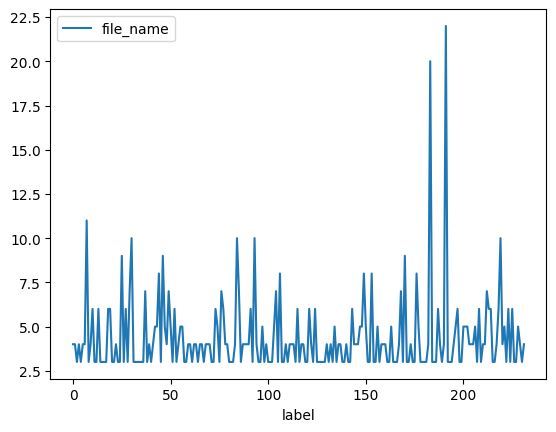

In [8]:
# good to do a count plot to see the number of images each plant folder / label has

image_path_label_df.groupby('label').count().plot()

In [9]:
# plant with the most images in its folder - clearly its the American Pokweed
image_path_label_df[image_path_label_df['label'] == image_path_label_df.groupby('label').count()['file_name'].idxmax()]

,file_name,label
816,American Pokeweed/328085502.jpg,191
817,American Pokeweed/328067424.jpg,191
818,American Pokeweed/328066300.jpg,191
819,American Pokeweed/328062358.jpg,191
820,American Pokeweed/328064063.jpg,191
821,American Pokeweed/328068467.jpg,191
822,American Pokeweed/.DS_Store,191
823,American Pokeweed/328070767.jpg,191
824,American Pokeweed/328066273.jpg,191
825,American Pokeweed/328069196.jpg,191


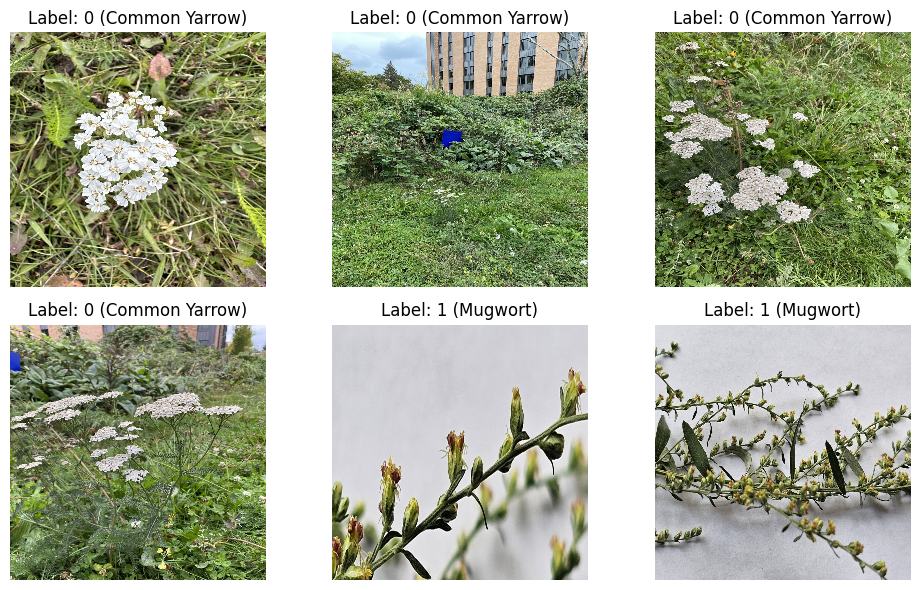

In [10]:
# To get a feeling for the dataset, it is always a good idea to plot a few samples

fig, ax = plt.subplots(2, 3, figsize=(10, 6))

idx = 0
for i in range(2):
    for j in range(3):
        
        label = image_path_label_df.label[idx]
        file_path = os.path.join(image_root_dir, image_path_label_df.file_name[idx])
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image
        image = cv2.resize(image, (256, 256))

        plant_name = image_path_label_df.file_name[idx].split("/")[0]
        
        ax[i,j].imshow(image)
        ax[i,j].set_title(f"Label: {label} ({plant_name})")
        ax[i,j].axis('off')
        idx = idx+1
        
plt.tight_layout()
plt.show()

In [11]:
# before proceeding building the data pipeline, lets do the train test split

train_df, test_df = train_test_split(image_path_label_df,
                                     test_size= 0.2,
                                     random_state= 42)

## Step 2: Building a Baseline

### 2.1 A data pipeline for loading images

In [12]:
# but before we proceed, lets instantiate a config object to hold our parameters - useful for any hyper parameter tuning down the line

config = SimpleNamespace()

# setting some basic configs
config.root_dir = image_root_dir
config.image_size = 256
config.normalise_mean = [0.485, 0.456, 0.406]
config.normalise_std = [0.229, 0.224, 0.225]
config.batch_size = 32


In [13]:
# we start by creating our custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform

    # returns the number of samples in our dataset
    def __len__(self):
        return len(self.img_labels)
    
    # constructor loads and returns a sample image (literally one image) from the dataset
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[index, 1]

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [14]:
# now we need to initialise a transformation pipeline for data augmentation - lets do one for train, test and validation

image_transforms = {
    'train': transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config.image_size, config.image_size)),  # Resize to a larger dimension first
    transforms.RandomRotation(30),  # Apply random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomVerticalFlip(),  # Flip vertically
    transforms.ToTensor(),
    transforms.Normalize(mean=config.normalise_mean, std=config.normalise_std) # Need to find the right values
    ]),

    'valid': transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config.image_size, config.image_size)),  # Resize to a larger dimension first
    transforms.CenterCrop(size=224),
    transforms.RandomVerticalFlip(),  # Flip vertically
    transforms.ToTensor(),
    transforms.Normalize(mean=config.normalise_mean, std=config.normalise_std)
    ]),  # Need to find the right values 

    'test': transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config.image_size, config.image_size)),  # Resize to a larger dimension first
    transforms.RandomRotation(10),  # Apply random rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=config.normalise_mean, std=config.normalise_std)
    ])  # Need to find the right values 
}

In [15]:
# lets move forward and create our custom dataset object

dataset = CustomImageDataset(img_labels=image_path_label_df,
                             img_dir=config.root_dir,
                             transform=image_transforms['train']
                             )

In [16]:
# next we need to provide dataloader the instance of the dataset

dataloader = DataLoader(dataset=dataset, 
                        batch_size=config.batch_size, 
                        shuffle=True, 
                        num_workers=0)


#### Note: 
The Dataloader returns the image batch and a label batch. The image_batch is a tensor of the shape (32, 3, 256, 256). This is a batch of 32 (batch_size) images with the shape (3, 256, 256) (color_channels, image_height, image_width). The label_batch is a tensor of the shape (32). These are the corresponding labels to the 32 images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch shape: torch.Size([32, 3, 256, 256])
Label batch shape: torch.Size([32])


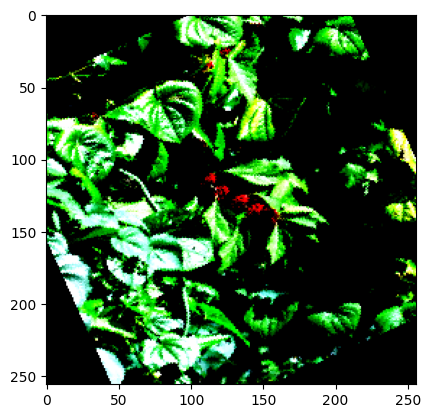

Label: 25


In [17]:
image_batch, label_batch = next(iter(dataloader))
print(f"Image batch shape: {image_batch.size()}")
print(f"Label batch shape: {label_batch.size()}")
img = image_batch[0].squeeze()
label = label_batch[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [18]:
# to avoid overfitting, let’s randomly partition the training data into training and validation sets

X = train_df
y = train_df.label

train_df, valid_df, y_train, y_test = train_test_split(X, 
                                                       y, 
                                                       test_size = 0.2, 
                                                       random_state = 42)

train_df

,file_name,label
367,Virginia Creeper/328060976.jpg,84
437,Marginal Wood Fern/328049947.jpg,99
711,Peruvian Zinnia/328095806.jpg,168
945,Parramatta Green Wattle/328072567.jpg,217
563,Florida Rosemary/328056075.jpg,132
...,...,...
451,Interrupted Fern/328073198.jpg,103
328,Crofton Weed/328063422.jpg,76
644,Butterfly Milkweed/328090706.jpg,151
852,Black Sheoak/328063647.jpg,196


In [19]:
# with this split, we can now create Datasets and Dataloaders for the training and validation data

train_dataset = CustomImageDataset(img_labels=train_df,
                                   img_dir=config.root_dir,
                                   transform=image_transforms['train'])

valid_dataset = CustomImageDataset(img_labels=valid_df,
                                   img_dir=config.root_dir,
                                   transform=image_transforms['valid'])

train_dataloader = DataLoader(train_dataset,
                              batch_size=config.batch_size,
                              shuffle=True,
                              num_workers=0)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=config.batch_size,
                              shuffle=False,
                              num_workers=0)

### 2.2 Prepare the Model

In [20]:
config.n_classes = image_path_label_df.label.nunique()

In [21]:
# Load a pretrained model and reset final fully connected layer.
model = models.resnet50(pretrained=True)

# Freezing the weights during transfer learning - we only want to train the last layer (fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Modify the last few layers to match your requirements
num_ftrs = model.fc.in_features  # Get the number of input features to the last fully connected layer

# Replace the last fully connected layer with a new one
model.fc = torch.nn.Linear(num_ftrs, config.n_classes)

In [22]:
model(image_batch).size()  # output is batch size and no. of classes in the final layer (fc layer)

torch.Size([32, 232])

In [23]:
summary(model, (3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        (128)
├─ReLU: 1-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Sequential: 1-5                        [-1, 256, 64, 64]         --
|    └─Bottleneck: 2-1                   [-1, 256, 64, 64]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 64, 64]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        (128)
├─ReLU: 1-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Sequential: 1-5                        [-1, 256, 64, 64]         --
|    └─Bottleneck: 2-1                   [-1, 256, 64, 64]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 64, 64]  

### 2.3 Setting up loss function, optimizer and learning rate scheduler

In [24]:
# loss function - selected loss function is ideal for a multi-class problem
config.criterion = nn.CrossEntropyLoss()
config.learning_rate = 0.001
config.lr_min = 0.0001
config.epochs = 5

# for the optimizer, lets use adam as it is really popular and has faster convergence than SGD
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate
)

# we would also need a learning rate scheduler - its purpose is to automatically modify the learning rate according to
# pre-defined schedule or rule, aiming to improve convergence and generalization of the model

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=np.ceil(len(train_dataloader.dataset) / config.batch_size) * config.epochs,
    eta_min=config.lr_min
)   # recommended lr scheduler for fine-tuning

In [26]:
# function to measure accuracy score

def calculate_metric(y, y_pred):
  metric = accuracy_score(y, y_pred)
  return metric